In [1]:
import pandas as pd
import matplotlib.pyplot as plt	
import seaborn as sns
import sys
import os
import numpy as np
from pathlib import Path

In [13]:
# Setting root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.preprocessing.easy_create_dataset import load_sensor_csv

# Loads csv files in dictionary
def create_sensor_dict(experiment_path):
    sensor_data_dict = {}
    for file in os.listdir(experiment_path):
        if file.endswith(".csv"):
            sensor_name = file.replace(".csv", "")
            path = experiment_path / file
            sensor_data_dict[sensor_name] = load_sensor_csv(path, sensor_name)
    return sensor_data_dict

{'Barometer':        Time (s)      X (hPa)     sensor
0     -0.503339  1008.783188  Barometer
1      0.528364  1008.778152  Barometer
2      1.560148  1008.773117  Barometer
3      2.591905  1008.762512  Barometer
4      3.623691  1008.754425  Barometer
..          ...          ...        ...
751  798.496428  1008.741989  Barometer
752  799.561854  1008.737793  Barometer
753  800.627261  1008.731842  Barometer
754  801.692684  1008.724442  Barometer
755  802.758065  1008.724442  Barometer

[756 rows x 3 columns], 'Linear Accelerometer':          Time (s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)                sensor
0        0.047833  -0.091182   0.048849   0.126928  Linear Accelerometer
1        0.067899  -0.118551  -0.071587   0.307531  Linear Accelerometer
2        0.087965  -0.180354  -0.139030   0.236570  Linear Accelerometer
3        0.108031  -0.347945  -0.220061   0.032875  Linear Accelerometer
4        0.128098  -0.373924  -0.234475  -0.049043  Linear Accelerometer
...           ...  

### 1. Cycling Experiment Visualization

In [21]:
cycling_experiment = project_root / "data" / "experiment_fietsen_puck"
cycling_experiment = create_sensor_dict(cycling_experiment)
print(cycling_experiment)

{'Barometer':        Time (s)      X (hPa)     sensor
0     -0.503339  1008.783188  Barometer
1      0.528364  1008.778152  Barometer
2      1.560148  1008.773117  Barometer
3      2.591905  1008.762512  Barometer
4      3.623691  1008.754425  Barometer
..          ...          ...        ...
751  798.496428  1008.741989  Barometer
752  799.561854  1008.737793  Barometer
753  800.627261  1008.731842  Barometer
754  801.692684  1008.724442  Barometer
755  802.758065  1008.724442  Barometer

[756 rows x 3 columns], 'Linear Accelerometer':          Time (s)  X (m/s^2)  Y (m/s^2)  Z (m/s^2)                sensor
0        0.047833  -0.091182   0.048849   0.126928  Linear Accelerometer
1        0.067899  -0.118551  -0.071587   0.307531  Linear Accelerometer
2        0.087965  -0.180354  -0.139030   0.236570  Linear Accelerometer
3        0.108031  -0.347945  -0.220061   0.032875  Linear Accelerometer
4        0.128098  -0.373924  -0.234475  -0.049043  Linear Accelerometer
...           ...  

In [14]:
def plot_sensor_data(sensor_data_dict, time_col="Time (s)"):
    axis_colors = {
        'X': '#FF5733',   # Rood/oranje
        'Y': '#33FF57',   # Groen
        'Z': '#3357FF'    # Blauw
    }

    fig, axs = plt.subplots(len(sensor_data_dict), 1, figsize=(15, 4 * len(sensor_data_dict)), sharex=True)

    if len(sensor_data_dict) == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, sensor_data_dict.items()):
        if time_col not in df.columns:
            continue

        df = df.dropna()
        # Filter alleen numerieke kolommen plus de tijdskolom
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        if time_col not in numeric_cols:
            numeric_cols.insert(0, time_col)
            
        df = df[numeric_cols]
        time = df[time_col]

        for col in df.columns:
            if col == time_col:
                continue

            # Zoek naar 'X', 'Y', of 'Z' in de kolomnaam
            axis_key = next((k for k in axis_colors if k in col), None)
            color = axis_colors.get(axis_key, None)

            ax.plot(time, df[col], label=col, color=color)

        ax.set_title(label)
        ax.legend(loc='upper right')
        ax.grid(False)

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()


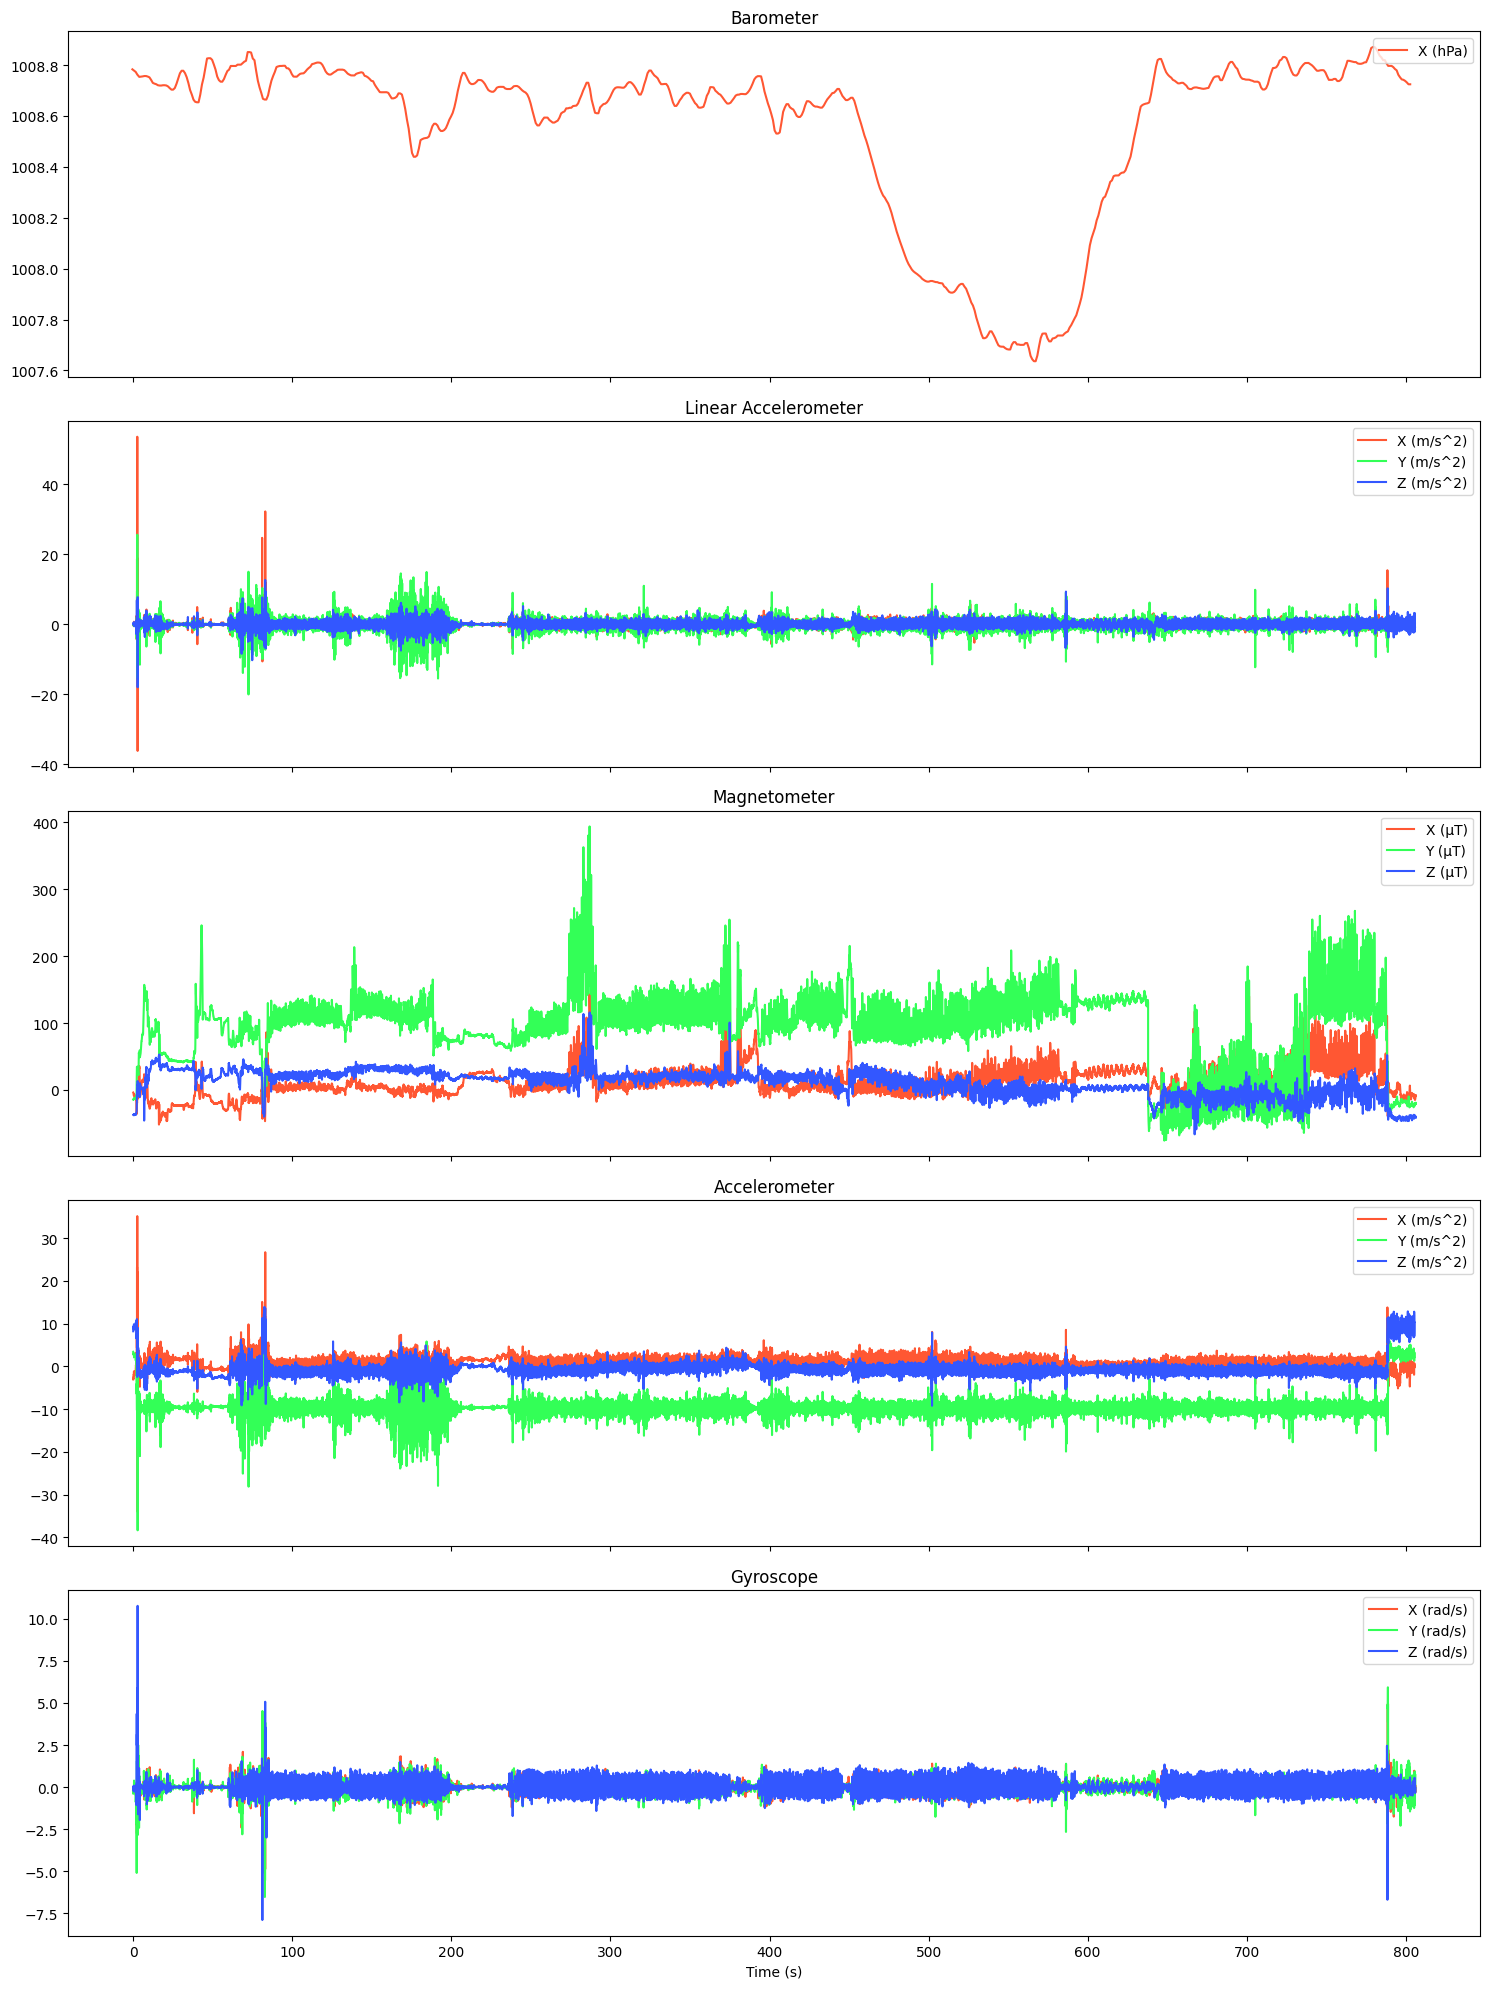

In [15]:
plot_sensor_data(cycling_experiment)

In [16]:
from src.preprocessing.remove_noise import detect_outliers

def plot_outliers(sensor_data_dict, time_col="Time (s)"):
    axis_colors = {
        'X': '#FF5733',   # Rood/oranje
        'Y': '#33FF57',   # Groen
        'Z': '#3357FF'    # Blauw
    }

    fig, axs = plt.subplots(len(sensor_data_dict), 1, figsize=(15, 4 * len(sensor_data_dict)), sharex=True)

    if len(sensor_data_dict) == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, sensor_data_dict.items()):
        if time_col not in df.columns:
            continue

        df = df.copy().dropna()
        time = df[time_col]

        for col in df.columns:
            if col == time_col or not np.issubdtype(df[col].dtype, np.number):
                continue

            axis_key = next((k for k in axis_colors if k in col), None)
            color = axis_colors.get(axis_key, 'gray')

            outliers = detect_outliers(df[col])
            ax.plot(time, df[col], label=f"{col} Raw", color=color, alpha=0.4)
            ax.scatter(time[outliers], df[col][outliers], color='black', s=10, label=f"{col} Outliers", zorder=5)

        ax.set_title(f"{label} (Outliers)")
        ax.grid(False)

        # Legend outside the plot
        ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0.)

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # room for legends on the right
    plt.show()


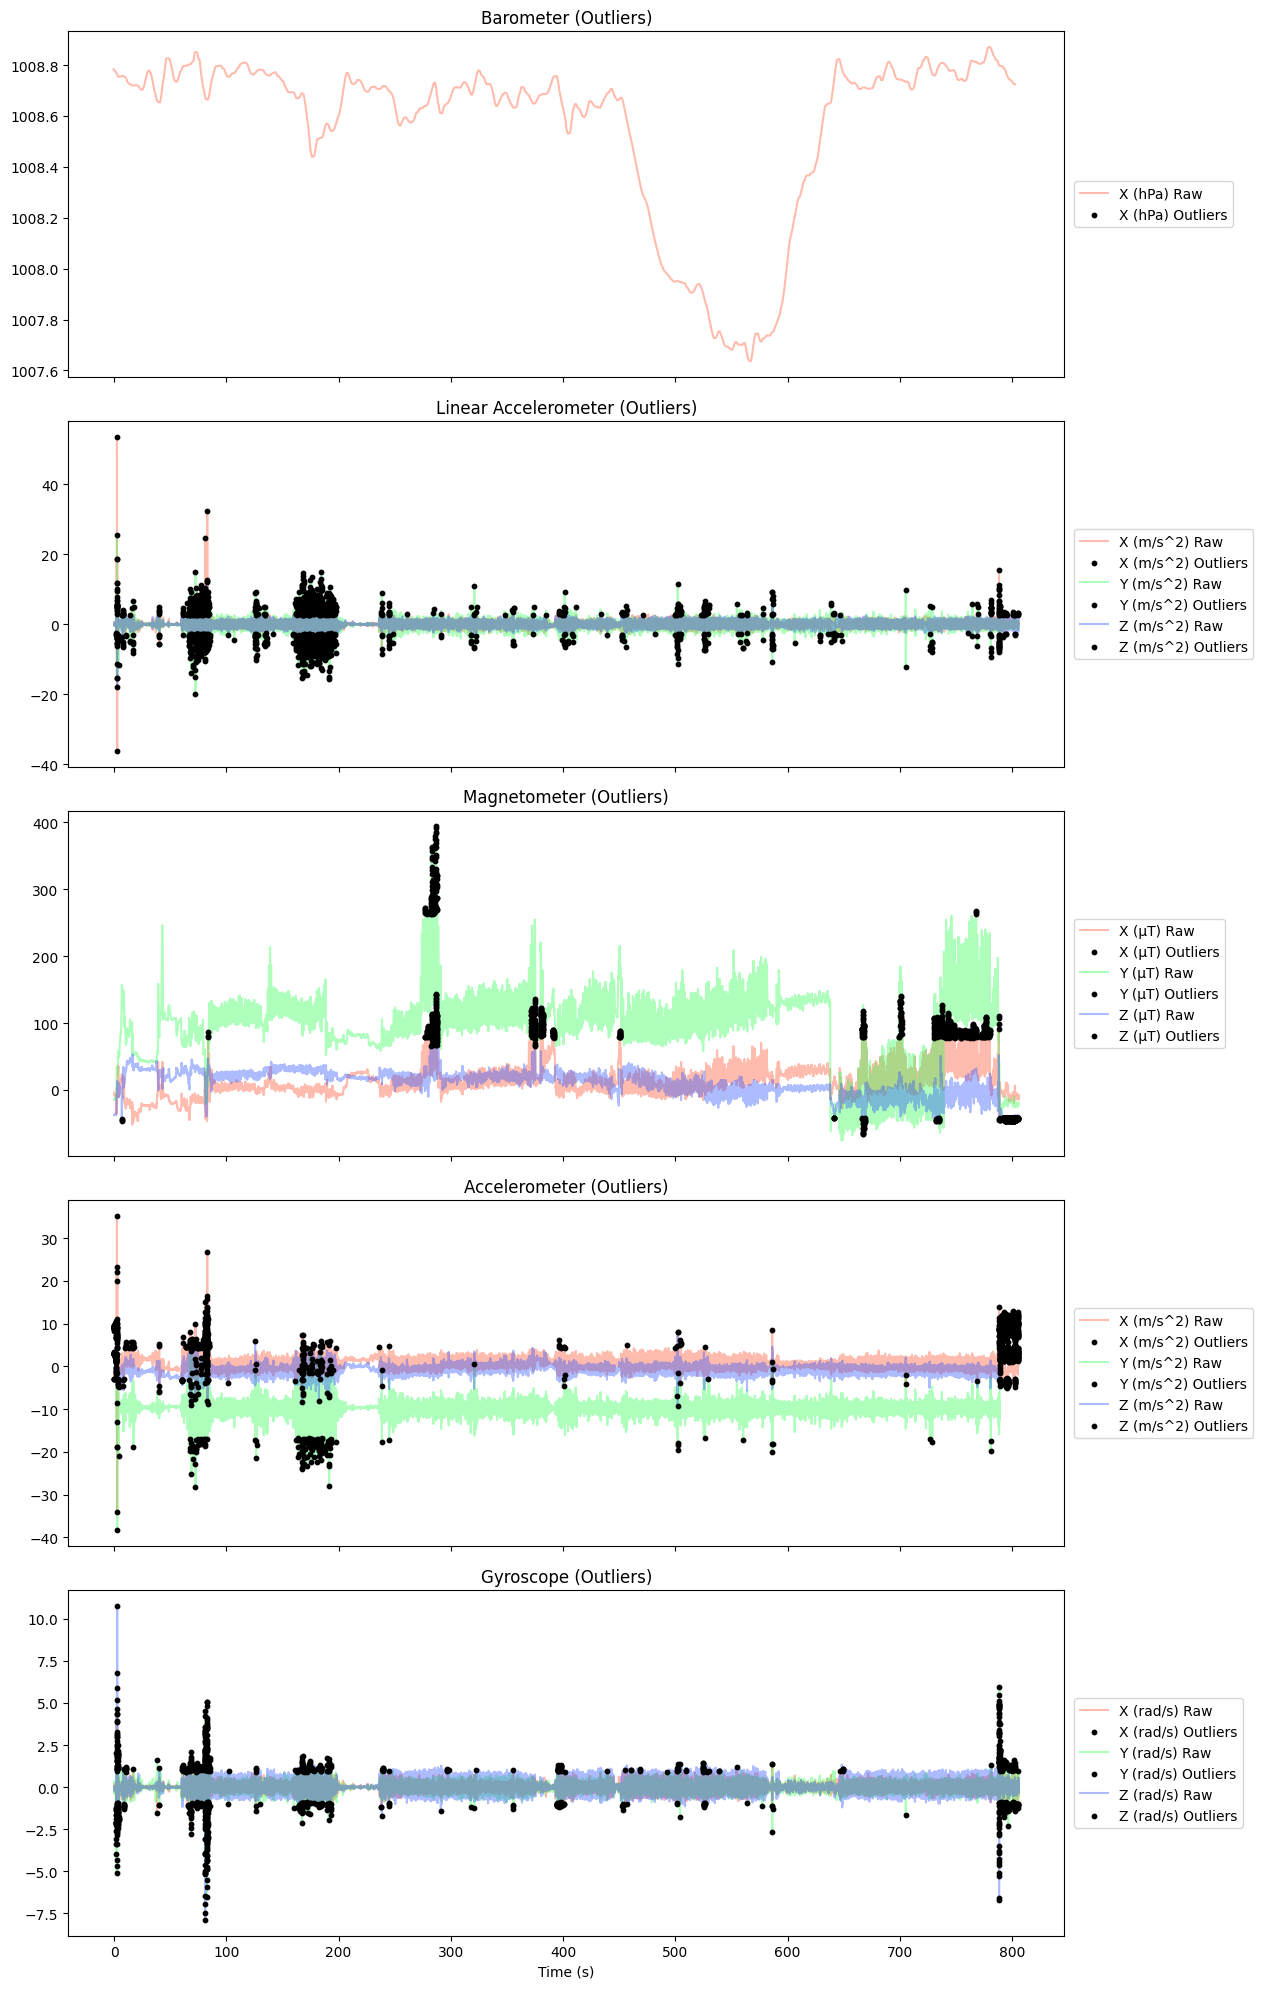

In [17]:
plot_outliers(cycling_experiment)

In [18]:
from src.preprocessing.remove_noise import detect_outliers, apply_kalman_filter

def plot_kalman_filtered(sensor_data_dict, time_col="Time (s)"):
    axis_colors = {
        'X': '#FF5733',   # Red/Orange
        'Y': '#33FF57',   # Green
        'Z': '#3357FF'    # Blue
    }

    fig, axs = plt.subplots(len(sensor_data_dict), 1, figsize=(15, 4 * len(sensor_data_dict)), sharex=True)

    if len(sensor_data_dict) == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, sensor_data_dict.items()):
        if time_col not in df.columns:
            continue

        df = df.copy().dropna()
        time = df[time_col]

        for col in df.columns:
            if col == time_col or not np.issubdtype(df[col].dtype, np.number):
                continue

            axis_key = next((k for k in axis_colors if k in col), None)
            color = axis_colors.get(axis_key, 'gray')

            # outliers = detect_outliers(df[col])
            # cleaned = df[col].mask(outliers).interpolate().bfill().ffill()
            kalman_smoothed = apply_kalman_filter(df[col])

            ax.plot(time, df[col], label=f"{col} Raw", color=color, alpha=0.2)
            ax.plot(time, kalman_smoothed, label=f"{col} Kalman", color=color, linewidth=2)

        ax.set_title(f"{label} (Kalman Filtered)")
        ax.grid(False)
        ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0.)

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()


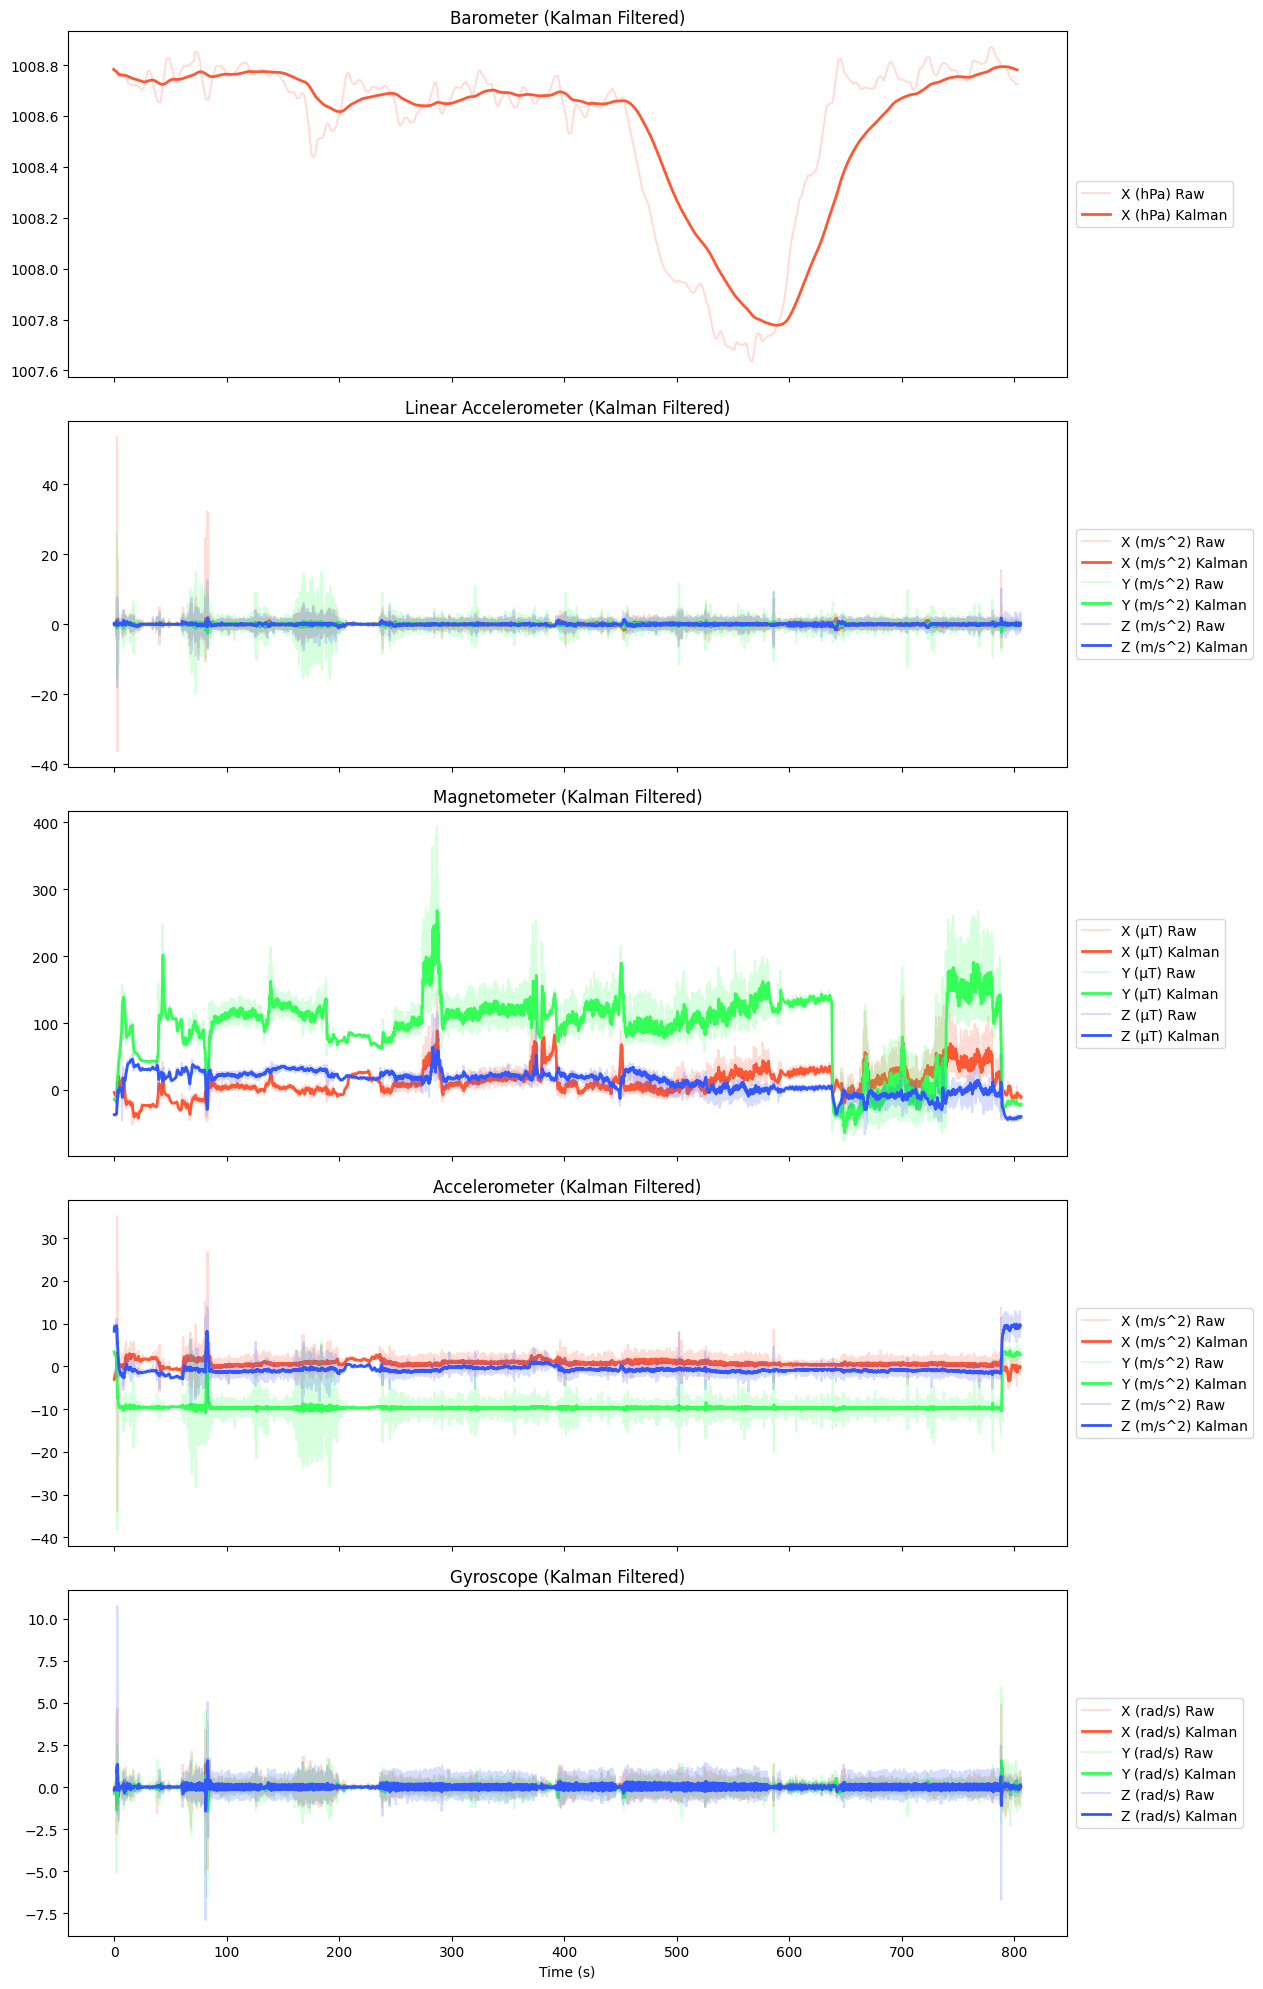

In [20]:
plot_kalman_filtered(cycling_experiment)

### 2. Metro Experiment Visualization

### 3. Driving Experiment Visualization

### 4. Running Experiment Visualization

### 5. Train Experiment Visualization